In [1]:
##Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

In [2]:
#Deeplearning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import preprocessing

#Initiate the random_seed
random_seed = 42 #what's the meaning of life again? 
random_seed = 15 #first baseball jersey


#Lets import the trtaining data 


In [3]:
training_data = pd.read_csv('./alphaseq_data_train.csv')
sample = training_data[:300]
print(training_data.head())
print('___________________')
print(training_data.describe())
print('___________________')
print(str(training_data.shape[0]) + '  rows' + ', ' + str(training_data.shape[1]) + '  columns')

#Check for missing values
missing_kd = training_data['Kd'].isnull().sum()
missing_kd_lower_bound = training_data['Kd_lower_bound'].isnull().sum()
missing_kd_upper_bound = training_data['Kd_upper_bound'].isnull().sum()
missing_q = training_data['q_value'].isnull().sum()


if missing_kd:
    print('There are ' + str(missing_kd) + ' missing values in the Kd column')
if missing_kd_lower_bound:
    print('There are ' + str(missing_kd_lower_bound) + ' missing values in the Kd_lower_bound column')
if missing_kd_upper_bound:
    print('There are ' + str(missing_kd_upper_bound) + ' missing values in the Kd_upper_bound column')
if missing_q:
    print('There are ' + str(missing_q) + ' missing values in the q column')

#Create a new potential feature -> the difference in bounds for Kd_lower_bound and Kd_upper_bound
training_data['Kd_bound_diff'] = training_data['Kd_upper_bound'] - training_data['Kd_lower_bound']
training_data['Kd_bound_diff'].fillna(0, inplace = True)




  description_a                                         sequence_a  \
0          WT_0  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
1          WT_1  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
2         WT_10  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
3         WT_11  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
4         WT_12  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   

    description_alpha                                     sequence_alpha  \
0  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
1  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
2  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
3  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
4  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   

         Kd  Kd_lower_bound  Kd_upper_bound  q_value  
0  1.241963        1.191959        1.291968      0.0  
1  1.379355 

/var/folders/9j/6jx2ypd90v7fxy19gd_2tz3c0000gn/T/ipykernel_15895/1827834902.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data['Kd_bound_diff'].fillna(0, inplace = True)


### There are about 691 sequence predictions where the Kd column is missing a value. We have a couple of ways to approach this 
1) We can exclude them (the easiest option - why would we try to predict a value we don't have data for?)
2) We can try to re-create it using the lower bound and the upper bound (we can just take the mid-point)
3) if the midpoint is still null we'll just take the lower bound. 

ASSUMPTION: "All measurements in the data are valid data points, including the duplicates."


In [4]:
#Lets create a flag identifying those sequence interactions that don't have a Kd value and create a supplement by finding the half way point between the Kd_lower_bound and the Kd_upper_bound
training_data['missing_Kd'] = training_data['Kd'].isnull().astype(float)

# Create a supplement by finding the halfway point between the Kd_lower_bound and the Kd_upper_bound
training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd'] = (training_data['Kd_upper_bound'] - (training_data['Kd_bound_diff'] / 2))

#If still null we'll just take the upper bound
training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd'] = training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd_upper_bound']

#If still null we'll just take lower bound
training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd'] = training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd_lower_bound']


In [ ]:
#Check for missing values with
training_data['Kd'].isnull().sum()

### Lets do some data exploration and feature generation 

1) We'll start with an exploration of the Kd values. Key points we're looking for: 
    - Are there outlier sequences where the Kd ratio significantly outside the norm?
        - Mark them with a row based label - "outlier"
    - How wide is the bound_diff between upper_bound and lower_found Kd values? 
        - What does it meant if the bound_diff is very large?
2) After that, we'll take a look at the sequences. We want to understand
    - Are there length trends?
    - Are there trends in the frequency of amino acids?
    - What is the relationship of description_a to sequence_a and description_alpha to sequence_alpha
    - We should expect the following new features to come out of this analysis:
        - sequence length for sequence_a and sequence_alpha
        - Amino Acid distribution for sequence_a and sequence_alpha
3) Next, we'll move on correlation analyses. Is there a correlation between the Kd values and the sequences, descriptors, or even the amino acids found within the training data?
    - 

In [5]:
#Lets create a function that shows us the distribution of any continuous variable within the data
#Bins is calculated by using Scott's Rule: bins = int((3.5 * np.std(data[column])) / (len(data[column])**(1/3)))

def histogram_plot_distribution(data, column, bins_manual):
    
    #print(np.std(data[column]), '--- std')
    iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
    #print(iqr, '  ---- IQR ')
    bins = (2*iqr)/(len(data[column])**(1/3))
    #print(bins, ' ---- number of suggested bins using Freedman - Diaconis Rule')
    
    if int(bins) > 10:
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    elif isinstance(bins_manual, int):
        print('we used manual bins')
        bins = bins_manual
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    
    else:
        print('we used manual bins')
        bins = 400
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    
    plt.xlabel(column +' values')
    plt.ylabel('Frequency')
    
    return plt.show()

def boxplot_distribution_outlier_analysis(data, column):
    ax = sns.boxplot(x=data[column])
    ax.set_title('Box plot: Distribution of ' + column + ' values for the training data')
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1-1.5*iqr
    upper_whisker = q3+1.5*iqr

    # Check if the whiskers are within the data range
    lower_whisker = max(lower_whisker, data[column].min())
    upper_whisker = min(upper_whisker, data[column].max())

    print('The lower whisker is at:', lower_whisker)
    print('The upper whisker is at:', upper_whisker)

    # Get the whisker values
     # Adding labels to the whiskers
    plt.annotate(f'{lower_whisker:.2f}', xy=(0, lower_whisker), xytext=(0, -20),
                 textcoords='offset points', ha='center', va='top', fontsize=10, color='blue')
    
    plt.annotate(f'{upper_whisker:.2f}', xy=(0, upper_whisker), xytext=(0, 20),
                 textcoords='offset points', ha='center', va='bottom', fontsize=10, color='blue')
    
    plt.draw()  # This ensures the plot is fully rendered before we display it
    plt.show()
    return lower_whisker, upper_whisker


we used manual bins


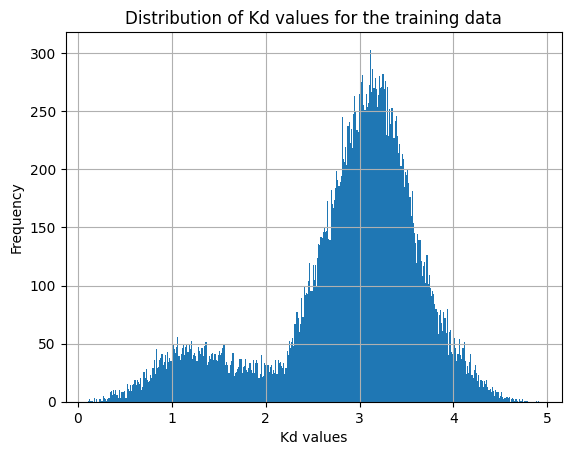

The lower whisker is at: 1.4233289521754073
The upper whisker is at: 4.562420121911141


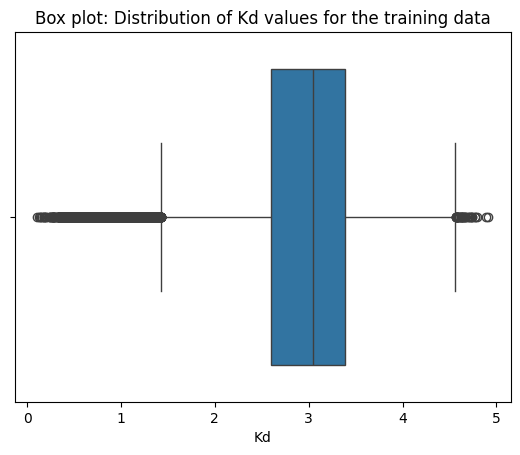

______________________________
we used manual bins


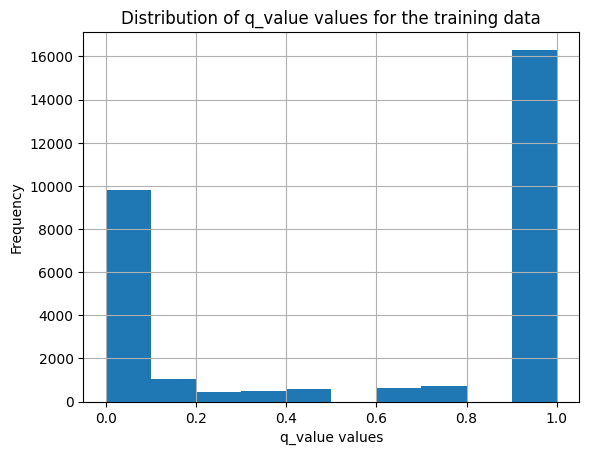

The lower whisker is at: 0.0
The upper whisker is at: 1.0


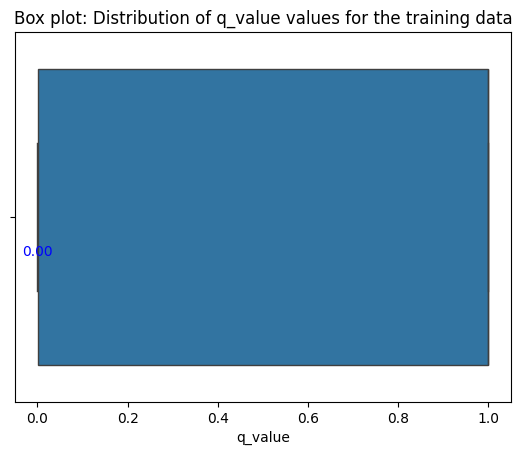

______________________________
we used manual bins


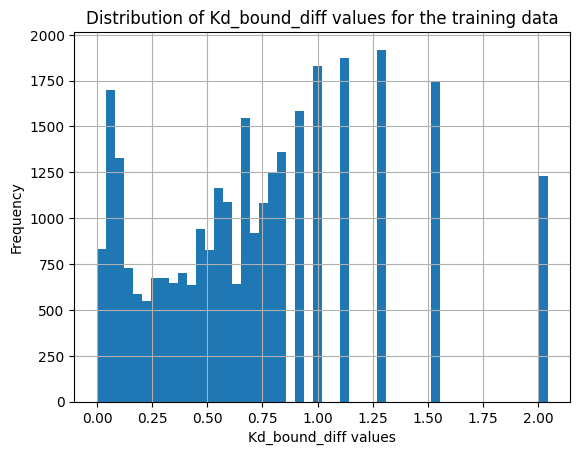

The lower whisker is at: 0.0
The upper whisker is at: 1.9734899480447812


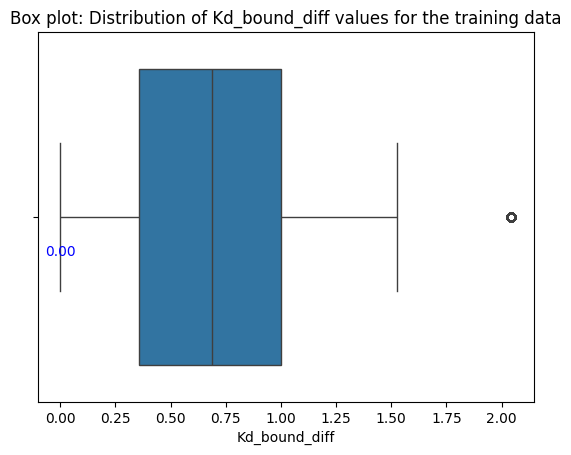

In [6]:
#Create first distribution plots and identify outliers
histogram_plot_distribution(data = training_data, column = 'Kd', bins_manual = 400)
kd_lower_whisker, kd_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'Kd')
print('______________________________')
histogram_plot_distribution(training_data, 'q_value', bins_manual = 10)
q_value_lower_whisker, q_value_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'q_value')
print('______________________________')
histogram_plot_distribution(training_data, 'Kd_bound_diff', bins_manual = 50)
kd_diff_lower_whisker, kd_diff_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'Kd_bound_diff')

### Takeaways from distribution analysis
1) Most Kd values hover around 3, there's a significantly longer and larger low tail shown in the histogram plot. This implies that most of the sequences are binding very well. It would be worth looking at how q_value and Kd correlate. If the exceptionally well binding sequences are 
2) Over half of the provided samples are likely to fail the null hypothesis with large q_values. This suggests that we may not be able to trust the Kd measurements for the these sequence interactions as much. 

In [7]:
training_data.head()

,description_a,sequence_a,description_alpha,sequence_alpha,Kd,Kd_lower_bound,Kd_upper_bound,q_value,Kd_bound_diff,missing_Kd
0,WT_0,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.241963,1.191959,1.291968,0.0,0.100009,0.0
1,WT_1,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.379355,1.318349,1.440361,0.0,0.122012,0.0
2,WT_10,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.152859,1.120984,1.184735,0.0,0.063751,0.0
3,WT_11,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.123487,1.082745,1.164230,0.0,0.081485,0.0
4,WT_12,QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...,huPD-1_RE(rebuilt),LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...,1.161713,1.128016,1.195410,0.0,0.067393,0.0


In [8]:
#Lets now label the datapoints within the training set that are Kd, q_value, or Kd_bound_diff outliers

#Number of Kd outliers
training_data['Kd_outlier'] = np.where((training_data['Kd'] < kd_lower_whisker) | (training_data['Kd'] > kd_upper_whisker), 1, 0)
print(len(training_data[training_data['Kd_outlier'] == 1]), '  Kd outliers')
print(len(training_data[training_data['Kd'] < kd_lower_whisker]), '  Kd lower whisker outliers')
print(len(training_data[training_data['Kd'] > kd_upper_whisker]), '  Kd upper whisker outliers')

print('____________________________')

#Number of q_value outliers
training_data['q_value_outlier'] = np.where((training_data['q_value'] < q_value_lower_whisker) | (training_data['q_value'] > q_value_upper_whisker), 1, 0)
print(len(training_data[training_data['q_value_outlier'] == 1]), ' q_value outliers')

print('____________________________')

#Number of Kd_bound_diff outliers
training_data['Kd_bound_diff_outlier'] = np.where((training_data['Kd_bound_diff'] < kd_diff_lower_whisker) | (training_data['Kd_bound_diff'] > kd_diff_upper_whisker), 1, 0)
print(len(training_data[training_data['Kd_bound_diff_outlier'] == 1]), 'k d_bound_diff outliers')
print(len(training_data[training_data['Kd_bound_diff'] < kd_diff_lower_whisker]), '  Kd_bound_diff lower whisker outliers')
print(len(training_data[training_data['Kd_bound_diff'] > kd_diff_upper_whisker]), '  Kd_bound_diff upper whisker outliers')

2677   Kd outliers
2643   Kd lower whisker outliers
34   Kd upper whisker outliers
____________________________
0  q_value outliers
____________________________
1231 k d_bound_diff outliers
0   Kd_bound_diff lower whisker outliers
1231   Kd_bound_diff upper whisker outliers


It seems that there are approximately 2552 Kd outliers and 1231 Kd_bound_diff outliers. The large majority of Kd outliers come from the lower bound whisker. This implies that these proteins may be especially well binding according to Kd meaning. 
All K_bound_diff outlier values are high outliers. This suggests that these are predictions where Kd has a larger level of uncertainty

In [9]:
#Lets check some counts. Are there duplicate descriptions or sequence_a?

unique_sequence_as = len(training_data['sequence_a'].unique())
unique_description_as = len(training_data['description_a'].unique())
unique_sequence_alpha = len(training_data['sequence_alpha'].unique())
unique_description_alpha = len(training_data['description_alpha'].unique())

print('____________________________')
print('There are ' + str(unique_description_as) + ' unique description_a')
print('There are ' + str(unique_sequence_as) + ' unique sequence_a')
print('There are ' + str(unique_sequence_alpha) + ' unique sequence_alpha')
print('There are ' + str(unique_description_alpha) + ' unique description_alpha')
print('____________________________')

#Count of sequence_a per description
description_a_grouped = training_data.groupby('description_a').count()
description_a_counts = description_a_grouped['sequence_a']
description_a_grouped.reset_index(inplace=True)
if any(description_a_counts > 1):
    print('There are ' + str(len(description_a_grouped[description_a_grouped > 1])) + ' description_a with more than 1 sequence_a')
    mult_seqs = description_a_grouped.loc[description_a_grouped['description_a'] > 1, 'sequence_a'].tolist()

sequence_a_grouped = training_data.groupby('sequence_a').count()
sequence_a_counts = sequence_a_grouped['description_a']
sequence_a_grouped.reset_index(inplace=True)
if any(sequence_a_counts > 1):
    print('There are ' + str(len(sequence_a_counts[sequence_a_counts > 1])) + ' sequence_a with more than 1 description')
    #Print out the sequence_as with more than 1 description
    mult_descs = sequence_a_grouped.loc[sequence_a_grouped['description_a'] > 1, 'sequence_a'].tolist()


#Lets mark the sequence_as with mutliple descriptions with a flag
training_data['multiple_desc_a'] = np.where(training_data['sequence_a'].isin(mult_descs), 1, 0)

____________________________
There are 30049 unique description_a
There are 29883 unique sequence_a
There are 1 unique sequence_alpha
There are 1 unique description_alpha
____________________________
There are 105 sequence_a with more than 1 description


## Sequence Analysis
- Now that we've marked the duplicates lets take a closer look at the sequences to see if we can find anything interesting. 


we used manual bins


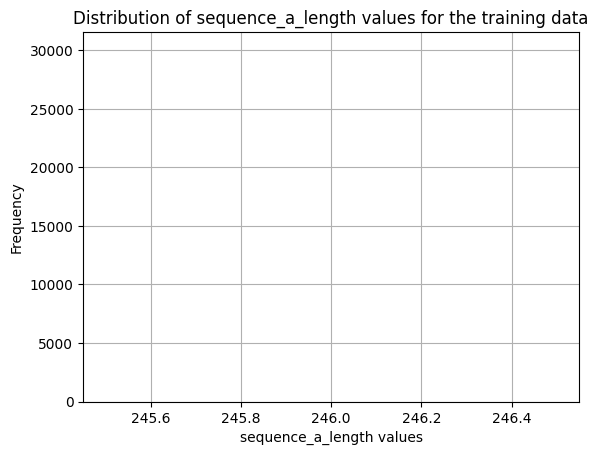

The lower whisker is at: 246.0
The upper whisker is at: 246.0


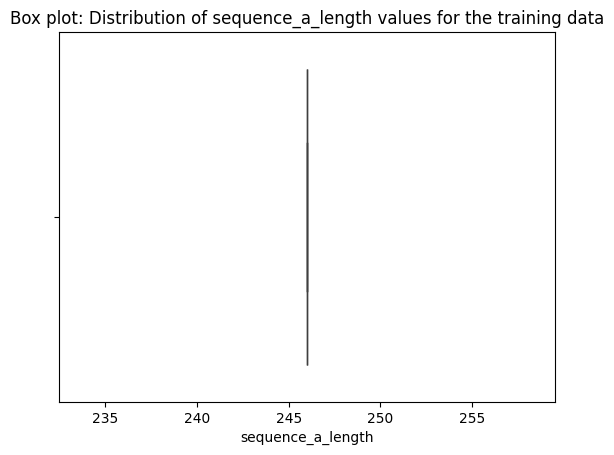

In [10]:
training_data['sequence_a_length'] = training_data['sequence_a'].apply(lambda x: len(x))

#Lets check the distribution of sequence_a lengths
histogram_plot_distribution(data = training_data, column = 'sequence_a_length', bins_manual = 400)
kd_lower_whisker, kd_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'sequence_a_length')

Ok, so that was a bit unexpected but it actually makes sense upon second thought! I initially assumed that we were looking at scFv variant of Pembrolizumabthat could differ in length but the instructions explicitly state that we are only looking at a window. The sequence_a values are all the same length because of the window

#Now lets look at the distribution of amino acids per variant



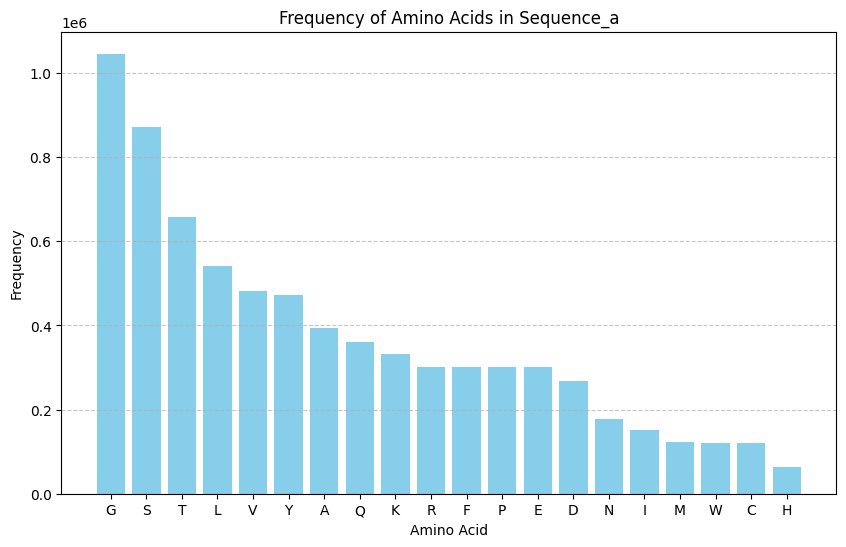

In [11]:
all_sequences_a = ''.join(training_data['sequence_a'])
all_amino_acids= Counter(all_sequences_a)

# Step 2: Create a DataFrame from the counter and plot
freq_df = pd.DataFrame(list(all_amino_acids.items()), columns=['Amino Acid', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(freq_df['Amino Acid'], freq_df['Frequency'], color='skyblue')
plt.title('Frequency of Amino Acids in Sequence_a')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ok, so that provides a list of all the unique amino acids. It also tells us that that most of the AAs are G. This doesn't really tell us much because we can't see a correlation between the sum of the Amino Acids present and the Kd values (or really another numerical value.) I'm curious to see if we can turn the amino acid frequency into a feature that we can use in our models

### Turn Amino Acid Frequency counts into features


In [12]:
ls_of_all_aa_columns = list(all_amino_acids.keys())


def amino_acid_count(sequence, amino_acid):
    return sequence.count(amino_acid)

for aa in list(all_amino_acids.keys()):
    training_data[aa + ' counts'] = training_data['sequence_a'].apply(lambda x: amino_acid_count(x, aa))


We've created many new features. It's time to take a closer look at the correlation between these parameters. This should tell us what may be good features and what may not be good features. We can worry about the data selection later considering we still need to split the data and adjust for the numerous outliers. 

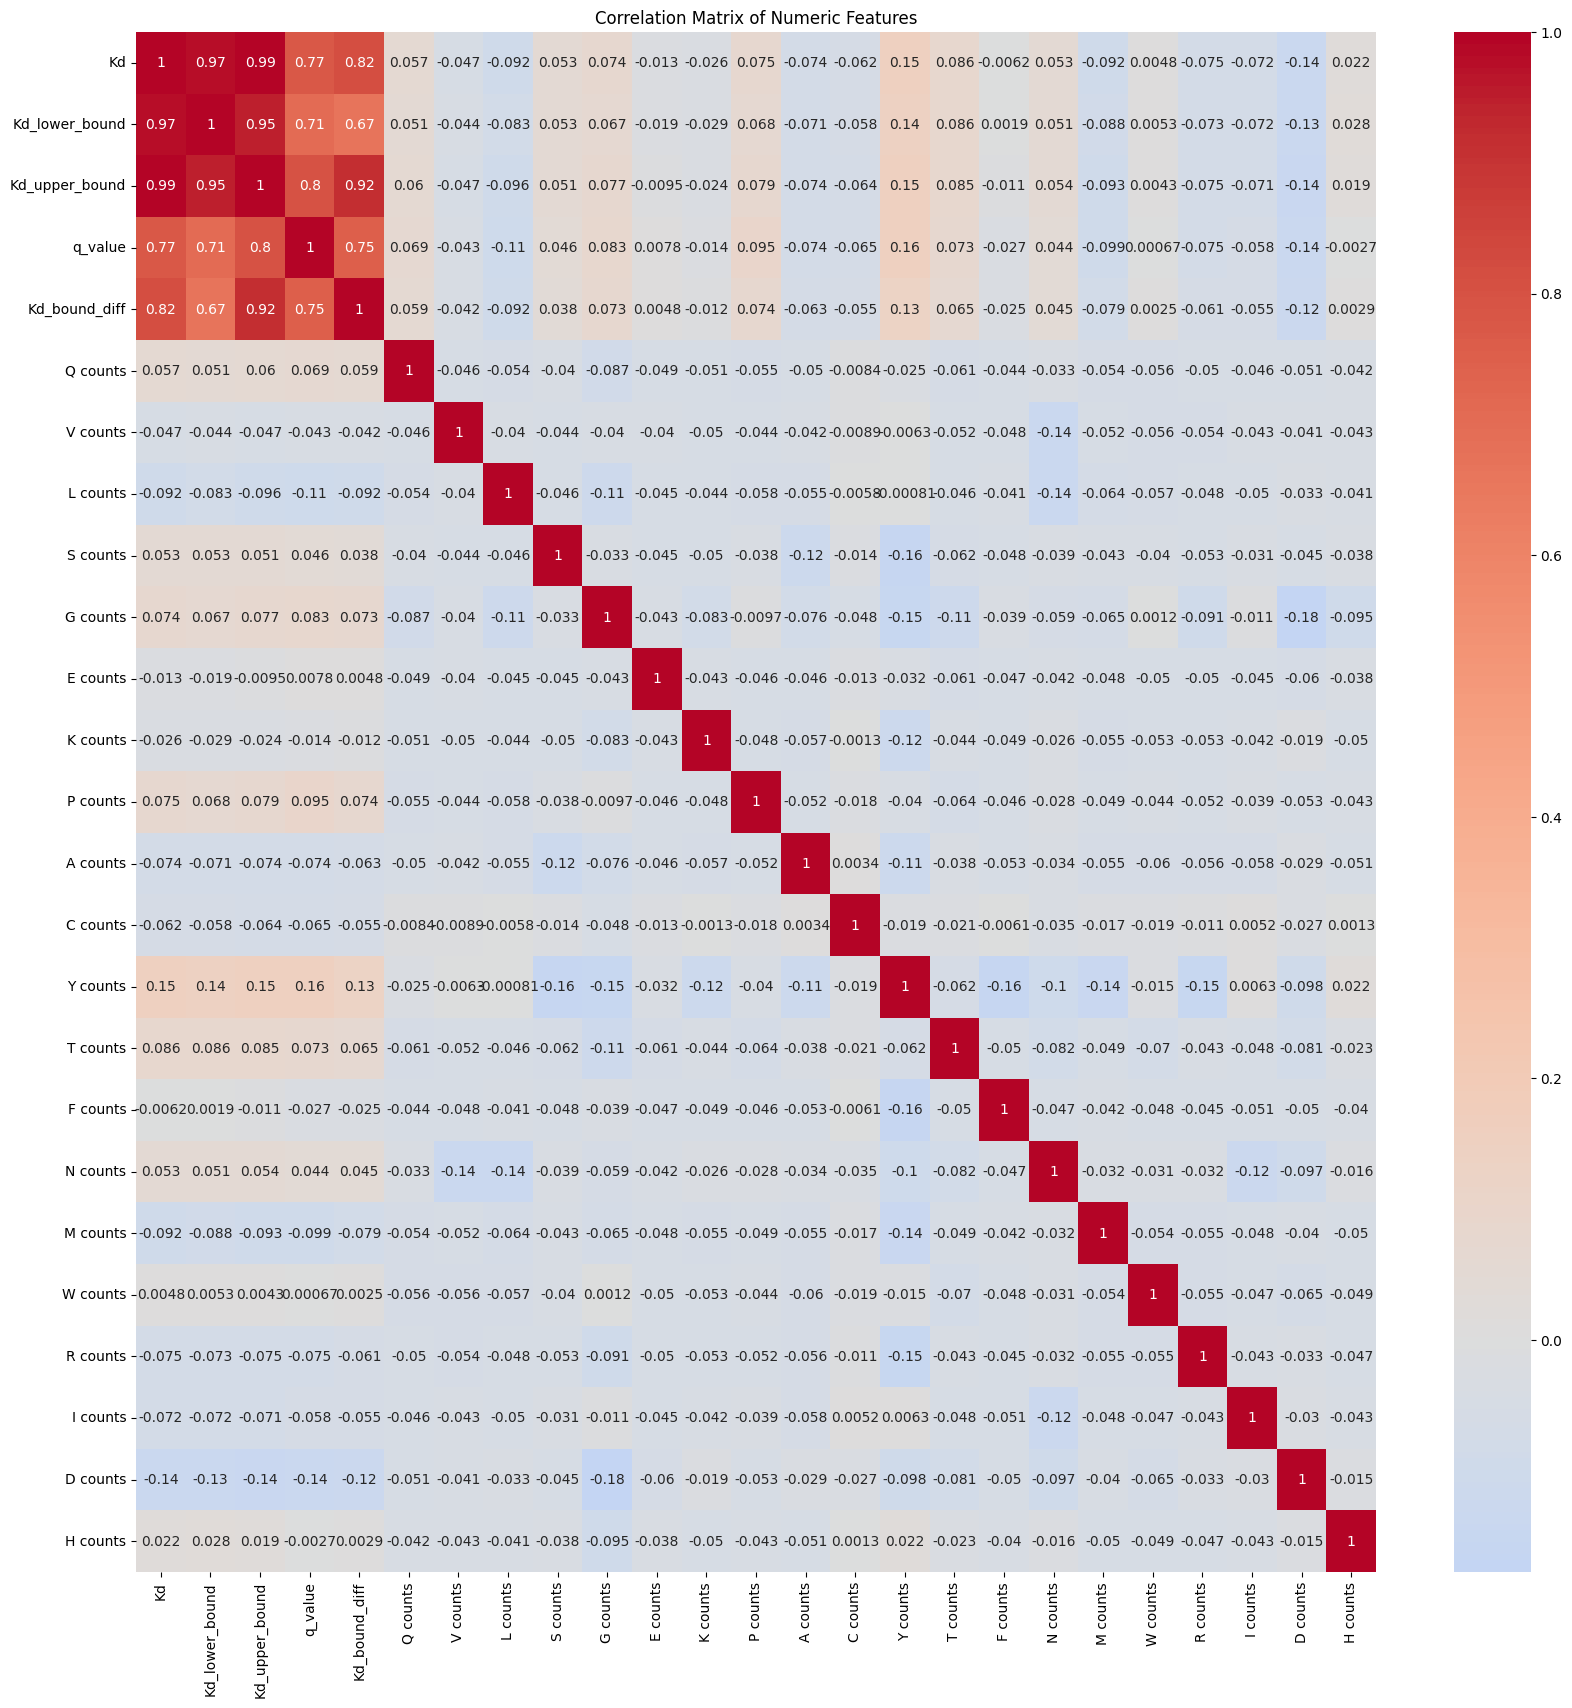

In [13]:
numeric_data = training_data[['Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'q_value', 'Kd_bound_diff',
                            'Q counts', 'V counts', 'L counts', 'S counts', 'G counts', 'E counts', 'K counts', 'P counts',
                            'A counts', 'C counts', 'Y counts', 'T counts', 'F counts', 'N counts',
                            'M counts', 'W counts', 'R counts', 'I counts', 'D counts', 'H counts']]


plt.figure(figsize = (20,20))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix of Numeric Features')
plt.show()

#### *Major takeaways:*
1) Counts of amino acids per sequence is not strongly correlated with Kd
2) q_value is positively correlated with Kd. **This one is particularly interesting. We were concerned that many of the strongly bound predictions with Kd would be statistically insignificant as illustrated by a high q_value. However, we do not see an inverse correlation here so I don't think that is what is happening.** 
3) We expected to see high correlation between the bounds vs Kd and bounds vs q_value. This makes sense given that the bounds can't differ _TOO_ much from the Kd


## Data Selection
Our experiments above indicate that there are significant numbers of [sequence_a][sequence_alpha] binding experiments that have outlier Kd values or unexpectedly high Kd_bound_diffs. Additionally, we've found instances where the same protein sequences have 2 different Kd values and 2 different descriptions. Personally, I'm the most concerned about instances with less precision in Kd_binding (represented by high Kd_bound_diffs) and the contradictory protein sequences. 

On top of that, the q_value indicated the likelihood that the data included is a false positive. A higher q_value represents a lower chance that the protein binding measurement is distinguishable from the null hypothesis and hance hence biologically irrelevant. 

I'll create datasets that exclude some or all of this information. 

Additionally, since we know that multiple sequence_as have more than one Kd, Kd_lower_bound, Kd_upper_bound, K_bound_diff, and q_value, I'll increlase a pamater that takes the max, min, mean of the values to produce the final data set. 

In [14]:
training_data_slices = {}

#Ok, great now lets create some data slices
def filter_dataset_for_split(data_to_split, 
                            treat_multiple_desc_a = "Max", 
                            ignore_high_q_value = 0.05,
                            ignore_kd_bound_diff = True, 
                            normalize_aa_counts = "MinMax",
                            list_of_aa_columns = []):
    #Ignore_high_q_value must be a float type data or False
    #We only ignore kd_bound_diff interactions if the value is high, this represents unexpectedly high variablility in Kd values
    #We can use this step to normalize 

    data = data_to_split.copy()

    if treat_multiple_desc_a:
        
        columns_to_transform = ['Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'Kd_bound_diff', 'q_value']
        for column in columns_to_transform:
            if treat_multiple_desc_a == "Max":
                data[column] = data.groupby('sequence_a')[column].transform('max')
            elif treat_multiple_desc_a == "Min":
                data[column] = data.groupby('sequence_a')[column].transform('min')
            elif treat_multiple_desc_a == "Avg":
                data[column] = data.groupby('sequence_a')[column].transform('mean')
            else:
                raise ValueError("Incorrect aggregation method used")

            
    else:
        print("we won't consider any sequences with multiple descriptions")
        data = data.loc[data['multiple_desc_a'] == 0, :]

        
    if ignore_high_q_value:
        data = data.loc[data['q_value'] < ignore_high_q_value, :]
    if ignore_kd_bound_diff:
        data = data.loc[data['Kd_bound_diff_outlier'] == 0,:]

    #We don't have to worry about the duplicates here because the sequences that are duplicates have the same AA count. 
    if normalize_aa_counts == "MinMax" and list_of_aa_columns:
        #We have 2 options for normalization: MinMaxScaling or using the StandardScaler
        scaler = preprocessing.MinMaxScaler()
        data[list_of_aa_columns] = scaler.fit_transform(data[list_of_aa_columns])
    elif normalize_aa_counts == 'Standard' and list_of_aa_columns:
        #We have 2 options for normalization: MinMaxScaling or using the StandardScaler
        scaler = preprocessing.StandardScaler()
        data[list_of_aa_columns] = scaler.fit_transform(data[list_of_aa_columns])
    elif not list_of_aa_columns:
        print("error submit aa_columns")
        return data

    return data

ls_aa_columns = [x for x in list(training_data.columns) if 'counts' in x ]

#Threshold for q_value exclusion is empirically determined
parameters_dictionary = [
                        {'include_all_q_values_MinMax':{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : False, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"MinMax"},
                         "exclude_high_q_values_MinMax":{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : 0.05, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"MinMax"},
                         'include_all_q_values_StandardScaler':{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : False, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"Standard"},
                         'exclude_all_q_values_StandardScaler':{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : 0.05, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"Standard"}}
                        ]

for param_dict in parameters_dictionary:
    for k,v in param_dict.items():
        treat_multiple_desc_a = v.get('treat_multiple_desc_a')
        ignore_high_q_value = v.get('ignore_high_q_value')
        ignore_kd_bound_diff = v.get('ignore_kd_bound_diff')
        normalize_aa_counts = v.get('normalize_aa_counts')
        training_data_slices[k] = filter_dataset_for_split(data_to_split = training_data,
                                                        treat_multiple_desc_a = treat_multiple_desc_a,
                                                        ignore_high_q_value=ignore_high_q_value,
                                                        normalize_aa_counts=normalize_aa_counts, 
                                                        list_of_aa_columns = ls_aa_columns)
                                                        


for k,v in training_data_slices.items():
    print(v.shape[0] , ' ------ sequences included when for {data_name}'.format(data_name = k))

28818  ------ sequences included when for include_all_q_values_MinMax
9293  ------ sequences included when for exclude_high_q_values_MinMax
28818  ------ sequences included when for include_all_q_values_StandardScaler
9293  ------ sequences included when for exclude_all_q_values_StandardScaler


## Modelling Approaches

- We can experiment with using a protein language model (or some other method to translate these proteins into embeddings for use in our models)
- We need at least one deep learning method. (lets explore 1Dimensional CNNs and RNNs given the importance of sequential order for our data)

In [15]:
#Select method
method = "CNN"

In [16]:
#check for any nukll values in Kd again before modelling
any(x for x in training_data_slices['include_all_q_values_MinMax']['Kd'].isnull())

#check for inconsistet data types
all(isinstance(x, float) for x in training_data_slices['include_all_q_values_MinMax']['Kd'])


True

### We have a number of ways to represent the sequences. One way is with one_hot_encode
- Below, create a function to one_hot_encode_sequences

In [32]:
# Define a custom Dataset class
class SequenceKdDataset(Dataset):
    def __init__(self, sequences, features, labels, encoding_type):
        self.sequences = sequences
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.encoding_type = encoding_type 
        self.amino_acid_mapping =  {
                                    'A': 0,  # Alanine
                                    'C': 1,  # Cysteine
                                    'D': 2,  # Aspartic Acid
                                    'E': 3,  # Glutamic Acid
                                    'F': 4,  # Phenylalanine
                                    'G': 5,  # Glycine
                                    'H': 6,  # Histidine
                                    'I': 7,  # Isoleucine
                                    'K': 8,  # Lysine
                                    'L': 9,  # Leucine
                                    'M': 10, # Methionine
                                    'N': 11, # Asparagine
                                    'P': 12, # Proline
                                    'Q': 13, # Glutamine
                                    'R': 14, # Arginine
                                    'S': 15, # Serine
                                    'T': 16, # Threonine
                                    'V': 17, # Valine
                                    'W': 18, # Tryptophan
                                    'Y': 19  # Tyrosine
                                }
    
    # Function to perform one-hot encoding
    def one_hot_encode(self, sequence):
        # Initialize the encoded sequence array
        encoded = np.zeros((len(sequence), len(self.amino_acid_mapping)), dtype=np.float32)
        for i, aa in enumerate(sequence):
            if aa in self.amino_acid_mapping:
                encoded[i, self.amino_acid_mapping[aa]] = 1.0
        return encoded
    #Function for indices
    def sequence_to_indices(self, sequence):
       
        # Convert the sequence to a list of indices
        indices = [self.amino_acid_mapping[aa] for aa in sequence if aa in self.amino_acid_mapping]
        return indices
    
    def __len__(self):
        return len(self.labels)
     

    def __getitem__(self, idx):
       
        sequence = self.sequences[idx]
        features = self.features[idx]
        label = self.labels[idx]

        if self.encoding_type == "one_hot":
            sequence_encoded = self.one_hot_encode(sequence)
        elif self.encoding_type == "embeddings":
            sequence_encoded = self.sequence_to_indices(sequence)
        
        #Use proper torch type for encoded sequences
        sequence_encoded = torch.tensor(sequence_encoded, dtype=torch.float32 if self.encoding_type == "one_hot" else torch.long)

        return sequence_encoded, features, label


In [34]:
# Assuming X contains features and y contains target variable (e.g., Kd values)
# Stratification presents an interesting opportunity. We could stratify according to q-value or the K-bound_diff values, this would presumbly make our dataset more effective at predicting only statistically significant protein-protein interactions.
#However, since we'll be predicting on a hold out set with no q_value for measured data it only affect training score not really our "test".
#We'll hold off on stratification for now but I think we should revisit it. 

aa_values = ['Q counts', 'V counts',
       'L counts', 'S counts', 'G counts', 'E counts', 'K counts', 'P counts',
       'A counts', 'C counts', 'Y counts', 'T counts', 'F counts', 'N counts',
       'M counts', 'W counts', 'R counts', 'I counts', 'D counts', 'H counts']

x_values = ['sequence_a'] + aa_values

segmented_datasets_for_training = {}

for k,v in training_data_slices.items():
  
   #If using non-deeplearning
   if method != 'CNN' and method != 'RNN':
         X = v[x_values]
         y = v['Kd']
         X['encoded_sequence']= X['sequence_a'].apply(lambda x:one_hot_encode(x))
         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)#, stratify=['q_value'])
         segmented_datasets_for_training[k] = {'X_train': X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}
         
   #If using deeplearning
   elif method == 'CNN' or method == 'RNN':
      print('we are in deeplearning')
      sequences = np.array(v['sequence_a']) #turn series to np away
      labels = np.array(v['Kd']) #turn series to np.array
      aa_features_tensor = torch.tensor(v[aa_values].to_numpy())

      #Initialize the DataSet
      dataset= SequenceKdDataset(sequences = sequences, features = aa_features_tensor,  labels = labels, encoding_type="embeddings")
      
      # Split dataset into training and validation sets
      train_size = int(0.8 * len(dataset))
      val_size = len(dataset) - train_size
      train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

      # Create data loaders
      train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

      segmented_datasets_for_training[k] = {'train_loader':train_loader, 'val_loader':val_loader}
    

we are in deeplearning
we are in deeplearning
we are in deeplearning
we are in deeplearning


/var/folders/9j/6jx2ypd90v7fxy19gd_2tz3c0000gn/T/ipykernel_15895/387905632.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/var/folders/9j/6jx2ypd90v7fxy19gd_2tz3c0000gn/T/ipykernel_15895/387905632.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/var/folders/9j/6jx2ypd90v7fxy19gd_2tz3c0000gn/T/ipykernel_15895/387905632.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtyp

### Sample Inspection of Training data slices
- We'll also use this to gather data lengths for the model

In [46]:
sample_dataset = segmented_datasets_for_training['include_all_q_values_MinMax']['train_loader']
for i, (sequences, aa_features, labels) in enumerate(sample_dataset):
    print(f"Batch {i+1}")
    print("Sequences Shape:", sequences.shape)
    print("Features Shape:", aa_features.shape)
    print("Labels Shape:", labels.shape)
    
    print("Sample Sequences:", sequences[0])  # Show the first sequence of the batch
    print("Sample AA Features:", aa_features[0])    # Show the first set of features of the batch
    print("Sample Labels:", labels[0])        # Show the first label of the batch
    
    if i == 0:  # Limit to printing details for the first two batches only
        break

encoded_sequence_length = sequences.shape[1]
    

Batch 1
Sequences Shape: torch.Size([64, 246])
Features Shape: torch.Size([64, 20])
Labels Shape: torch.Size([64])
Sample Sequences: tensor([13, 17, 13,  9, 17, 13, 15,  5, 17,  3, 17,  8,  8, 12,  5,  0, 15, 17,
         8, 17, 15,  1,  8,  0, 15,  5, 19, 16,  4, 16, 11, 19, 19, 10, 19, 18,
        17, 14, 13, 12, 12,  5, 13,  5,  9,  3, 18, 10,  5,  5,  7, 11, 12,  0,
        11,  5,  5, 16, 11,  4, 11,  3,  8,  4,  8, 11, 14, 17, 16,  9, 16, 16,
         2, 15, 15, 16, 16, 16,  0, 19, 10,  3,  9,  8, 15,  9, 13,  4,  2,  2,
        16,  0, 17, 19, 19,  1,  0, 14, 14,  2, 19, 14,  4,  2, 10,  5,  4,  2,
        19, 18,  5, 13,  5, 16, 16, 17, 16, 17, 15, 15,  5,  5,  5,  5, 15,  5,
         5,  5,  5, 15,  5,  5,  5,  5, 15,  3,  7, 17,  9, 16, 13, 15, 12,  0,
        16,  9, 15,  9, 15, 12,  5,  3, 14,  0, 16,  9, 15,  1, 14,  0, 15,  8,
         5, 17, 15, 16, 15,  5, 19, 15, 19,  9,  6, 18, 19, 13, 13,  8, 12,  5,
        13,  0, 12, 14,  9,  9,  7, 19,  9,  0, 15, 19,  9,  3, 15,

In [42]:
segmented_datasets_for_training['include_all_q_values_MinMax']['train_loader']

## Defining the model architecture



In [106]:
# Define the CNN models
class ProteinCNN(nn.Module):
    def __init__(self, **kwargs):
        super(ProteinCNN, self).__init__()
        # Assuming 20 channels for the 20 standard amino acids in one-hot encoding

        #Set default values
        self.sequence_length = kwargs.get('sequence_length', 246)
        self.num_additional_features = kwargs.get('num_additional_features',  0) #default to 0
        
        use_embedding_layer = kwargs.get('use_embedding_layer', False)
        self.use_embedding_layer = use_embedding_layer
        use_aa_features = kwargs.get('use_aa_features', False)
        self.use_aa_features = use_aa_features
        
        #Set parameters for convolution work
        embedding_dim = kwargs.get('embedding_dim',  64) #We'll start with a small embedding dimension
        conv_layer_kernel_size = kwargs.get('conv_layer_kernel_size', 3)
        pooling_kernel_size = kwargs.get('pooling_kernel_size',  2)
        pool_stride = kwargs.get('pool_stride',  2)
        conv_stride = kwargs.get('stride', 1)
        conv_dilation = kwargs.get('conv_dilation', 1)#We typically do not change dilation
        conv_padding = kwargs.get('conv_padding', (conv_layer_kernel_size - 1)//2) #standard way to dynamically determine padding


        #Lets define the architecture
        if use_embedding_layer:
            self.embedding = nn.Embedding(20, embedding_dim)
            self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim*2, kernel_size=conv_layer_kernel_size, padding=conv_padding, stride = conv_stride)
            self.conv2 = nn.Conv1d(in_channels=embedding_dim*2, out_channels=embedding_dim*4, kernel_size=conv_layer_kernel_size, padding=conv_padding, stride = conv_stride)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(kernel_size=pooling_kernel_size, stride = pool_stride)
            self.flatten = nn.Flatten()

           
            # Calculate dimensions after each layer for the calculation of tthe Lin1_layer_size
            output_size = self.sequence_length  # Initial input size
            output_size = self.calculate_output_size(input_size = output_size, kernel_size = conv_layer_kernel_size, stride = conv_stride, padding = conv_padding , dilation = conv_dilation )  # After first conv
            output_size = self.calculate_output_size(input_size = output_size, kernel_size = pooling_kernel_size, stride = pool_stride)     # After first pool
            output_size = self.calculate_output_size(input_size = output_size, kernel_size = conv_layer_kernel_size, stride = conv_stride, padding = conv_padding, dilation = conv_dilation)  # After second conv
            output_size = self.calculate_output_size(input_size = output_size, kernel_size = pooling_kernel_size, stride = pool_stride)    # After second pool


            #print(output_size, ' ---- this is the output size going into Lin1')

            if use_aa_features:
                Lin1_layer_size = (output_size * embedding_dim * 4) + self.num_additional_features
            else:
                Lin1_layer_size = (output_size * embedding_dim * 4)
                           
            self.Lin1 = nn.Linear(Lin1_layer_size, 128)
            self.Lin2 = nn.Linear(128, 1)

        else:
            self.conv1 = nn.Conv1d(in_channels=20, out_channels=40, kernel_size=conv_layer_kernel_size, padding=conv_padding, stride = conv_stride)
            self.conv2 = nn.Conv1d(in_channels=40, out_channels=80, kernel_size=conv_layer_kernel_size, padding=conv_padding, stride = conv_stride)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(kernel_size=pooling_kernel_size)

            self.flatten = nn.Flatten()

            output_size = self.calculate_output_size(input_size = self.sequence_length, pooling = True)

            Lin1_layer_size = output_size + self.num_additional_features
            
            self.Lin1 = nn.Linear(Lin1_layer_size, 128)
            self.Lin2 = nn.Linear(128, 1)



    def calculate_output_size(self, input_size, kernel_size=3, stride=1, padding=0, dilation=1):
        
        assert input_size>0, "Input size must be greater than 0"

        effective_kernel_size = dilation * (kernel_size - 1) + 1

        output_size = (((input_size + 2 * padding) - effective_kernel_size) // stride) + 1
        
        return output_size
        

    
    def forward(self, conv_data, additional_features):
        #This part of the code can be a bit confusing but I found it to be a quick and dirty method for experimenting
        
        #conv_data can be either the indices or the one hot encoded version of the sequencing data. 
        if self.use_embedding_layer:
            embedded_data = self.embedding(conv_data) #Embedding layer NOTE: Optional
            embedded_data = embedded_data.transpose(1,2) #Change to format for convolutional neural_network
            conv_data = embedded_data
        else:
            conv_data = conv_data.transpose(1,2) #Change to format for convolutional neural_network
        
        conv_data = self.conv1(conv_data) #First convolution
        conv_data = self.relu(conv_data) #First activation layer
        conv_data = self.pool(conv_data)# First pooling layer

        conv_data = self.conv2(conv_data) #second convolution
        conv_data = self.relu(conv_data)#Second activation layer
        conv_data = self.pool(conv_data)#Second pooling layer

        
        # Concatenate the additional features after flattening the output from convolutional layers
        conv_data = self.flatten(conv_data)
    
        #Include option in forward pass to use the additional features or to not
        if self.use_aa_features:
            #print(conv_data.shape, ' ---- shape of conv data')

            #print(additional_features.shape, ' ---- this is the shape of the additional features')
            conv_data = torch.cat((conv_data, additional_features), dim=1)
        else:
            #print(conv_data.shape, ' --- shape of convolutions after pooling')
            pass

        #Apply linear layer 1
        conv_data = self.Lin1(conv_data)

        #Introduce non-linearity
        conv_data = self.relu(conv_data)

        #Apply Linear layer 2
        conv_data = self.Lin2(conv_data)

        return conv_data

### Instantiating the model


In [118]:
# Instantiate and train the model
sequence_length = encoded_sequence_length #dynamically determined
num_additional_features = len(aa_values)#dynamically determined
use_aa_features = True
use_embedding_layer = True


#User determined, empirically determined


embedding_dimension = 64
conv_layer_kernel_size = 3
pooling_kernel_size = 2
pool_stride = 2
conv_stride = 1
conv_padding = 1
conv_dilation = 1

lr_rate = 0.001 


model = ProteinCNN(sequence_length = sequence_length,
                    num_additional_features = num_additional_features,
                    embedding_dim = embedding_dimension,
                    conv_layer_kernel_size = conv_layer_kernel_size,
                    pooling_kernel_size = pooling_kernel_size,
                    pool_stride = pool_stride,
                    conv_dilation = conv_dilation,
                    conv_stride = conv_stride,
                    use_aa_features = use_aa_features,
                    use_embedding_layer = use_embedding_layer)

loss_measurement = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr_rate)

# Move model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

61  ---- this is the output size going into Lin1


ProteinCNN(
  (embedding): Embedding(20, 64)
  (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Lin1): Linear(in_features=15636, out_features=128, bias=True)
  (Lin2): Linear(in_features=128, out_features=1, bias=True)
)

### Validation Code

In [119]:
 # Function to calculate loss on validation dataset
def validate(model, val_loader):
    model.eval()
    all_batch_val_loss = 0
    batch_val_samples = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for seqs, features, labels in val_loader:
            seqs = seqs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            #Update sequence with transpose to make compatible with CNN architecture
            
            outputs = model(conv_data = seqs,
                            additional_features = features
                            )

            loss = loss_measurement(outputs, labels)
            all_batch_val_loss += loss.item() * seqs.size(0)
            batch_val_samples += seqs.size(0)

            all_val_preds.append(outputs.detach())
            all_val_labels.append(labels)

    average_validation_loss = all_batch_val_loss  / batch_val_samples
    return average_validation_loss, all_val_preds, all_val_labels

In [120]:
## Training loop w/ valildation function. 
#We track performance across all epochs per training_data_slice/permutation. This way we can observe how performance changes with increased epochs

#Store historical performance:
history_across_all_training_slices = {}

num_epochs = 10
use_embedding_layer = True
use_aa_features = False

for pos, items in enumerate(training_data_slices.items()):
    k = items[0]
    v = items[1]
    print(k, ' ---- Training data slice for ')
   
    history = {
                'train_loss': [],
                'val_loss': [],
                'train_r2':[],
                'val_r2':[],
                'train_mae':[],
                'val_mae':[],
                'train_rmse':[],
                'val_rmse':[]
            }

    for epoch in range(num_epochs):

        if epoch%10 == 0:
            print('We are at epoch: ' + str(epoch))

        model.train()
        all_batch_train_loss = 0
        batch_samples = 0

        all_train_preds = []
        all_train_labels = []
        all_val_preds = []
        all_val_labels = []

        for batch, (seqs, features, labels) in enumerate(train_loader):


            seqs = seqs.to(device)
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(conv_data = seqs,
                            additional_features = features)  # Adjust dimensions for Conv1D
            
            all_train_preds.append(outputs.detach())
            all_train_labels.append(labels)
            loss = loss_measurement(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(loss, ' ---- this is the loss')
            #Add loss per batch and normalize per batch size
            all_batch_train_loss += loss.item() * seqs.size(0)
            batch_samples += seqs.size(0)

        avg_batch_training_loss = all_batch_train_loss / batch_samples
        #print(avg_batch_training_loss)
        
        # Validate after each epoch
        avg_validation_loss, epoch_val_preds, epoch_val_labels = validate(model, val_loader)

        # Converting lists to tensors
        train_preds = torch.cat(all_train_preds)
        train_labels = torch.cat(all_train_labels)
        val_preds = torch.cat(epoch_val_preds)
        val_labels = torch.cat(epoch_val_labels)

        # Calculate metrics for training
        history['train_r2'].append(r2_score(train_labels.numpy(), train_preds.numpy()))
        history['train_mae'].append(mean_absolute_error(train_labels.numpy(), train_preds.numpy()))
        history['train_rmse'].append(mean_squared_error(train_labels.numpy(), train_preds.numpy(), squared=False))
        
        # Calculate metrics for validation
        history['val_r2'].append(r2_score(val_labels.numpy(), val_preds.numpy()))
        history['val_mae'].append(mean_absolute_error(val_labels.numpy(), val_preds.numpy()))
        history['val_rmse'].append(mean_squared_error(val_labels.numpy(), val_preds.numpy(), squared=False))

        #Store the loss
        history['train_loss'].append(avg_batch_training_loss)
        history['val_loss'].append(avg_validation_loss)

        history_across_all_training_slices[k] = history
    

include_all_q_values_MinMax  ---- Training data slice for 
We are at epoch: 0
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features


/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(4.4633, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(12.4802, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5703, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(1.6446, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(2.0002, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(1.3598, grad_fn=<MseLossBackward0>)  ---- this is the los

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5146, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5038, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5013, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4478, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4612, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4018, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5068, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5412, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4523, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6431, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4496, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5919, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5513, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5694, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.3732, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.7375, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4861, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5507, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4626, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5178, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4192, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4664, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5364, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5314, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5432, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5535, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4821, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.5213, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5389, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5961, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5808, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4912, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5308, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.5507, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5348, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4942, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5164, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4470, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6055, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4208, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5818, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6237, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4898, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5220, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5600, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features


/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.5035, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5169, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.3893, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.3899, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4570, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5412, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.3213, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.5406, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5317, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5546, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4560, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4714, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5865, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4481, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4974, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6273, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4600, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4306, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6978, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4450, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5947, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5027, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5885, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5666, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4832, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.5906, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6316, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5308, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4114, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5403, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4532, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6042, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5934, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5322, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5155, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5495, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4312, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6386, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5215, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6228, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5757, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5141, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4378, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5971, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5486, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5558, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5355, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5777, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4618, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6147, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4303, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5165, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5350, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5538, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5179, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6416, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5682, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4036, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.3889, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4592, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.3556, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5529, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4266, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4218, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5243, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.7585, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6627, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4245, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.5973, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5335, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4891, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6073, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4663, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5778, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.5400, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4584, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4479, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4072, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4812, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5680, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5061, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.5243, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4178, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4236, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5452, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4801, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6238, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.5087, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6612, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4873, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5412, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5100, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5764, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5622, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.8016, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5502, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5586, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.3600, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.4103, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4982, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4785, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5169, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5594, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5917, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.3499, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features


/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.5985, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5711, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4444, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4930, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.6746, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4382, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer

tensor(0.6017, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5643, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5072, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4271, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5291, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5102, grad_fn=<MseLossBackward0>)  ---- this is the loss

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
torch.Size([64, 15616])  ---- sh

/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features


/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.4831, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4112, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5433, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5995, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.5617, grad_fn=<MseLossBackward0>)  ---- this is the loss
torch.Size([64, 15616])  ---- shape of conv data
torch.Size([64, 20])  ---- this is the shape of the additional features
tensor(0.4967, grad_fn=<MseLossBackward0>)  ---- this is the loss

## Evaluation time: Lets see some plots
- Ideally we wantto see all the training slices compared against each other on the same plots



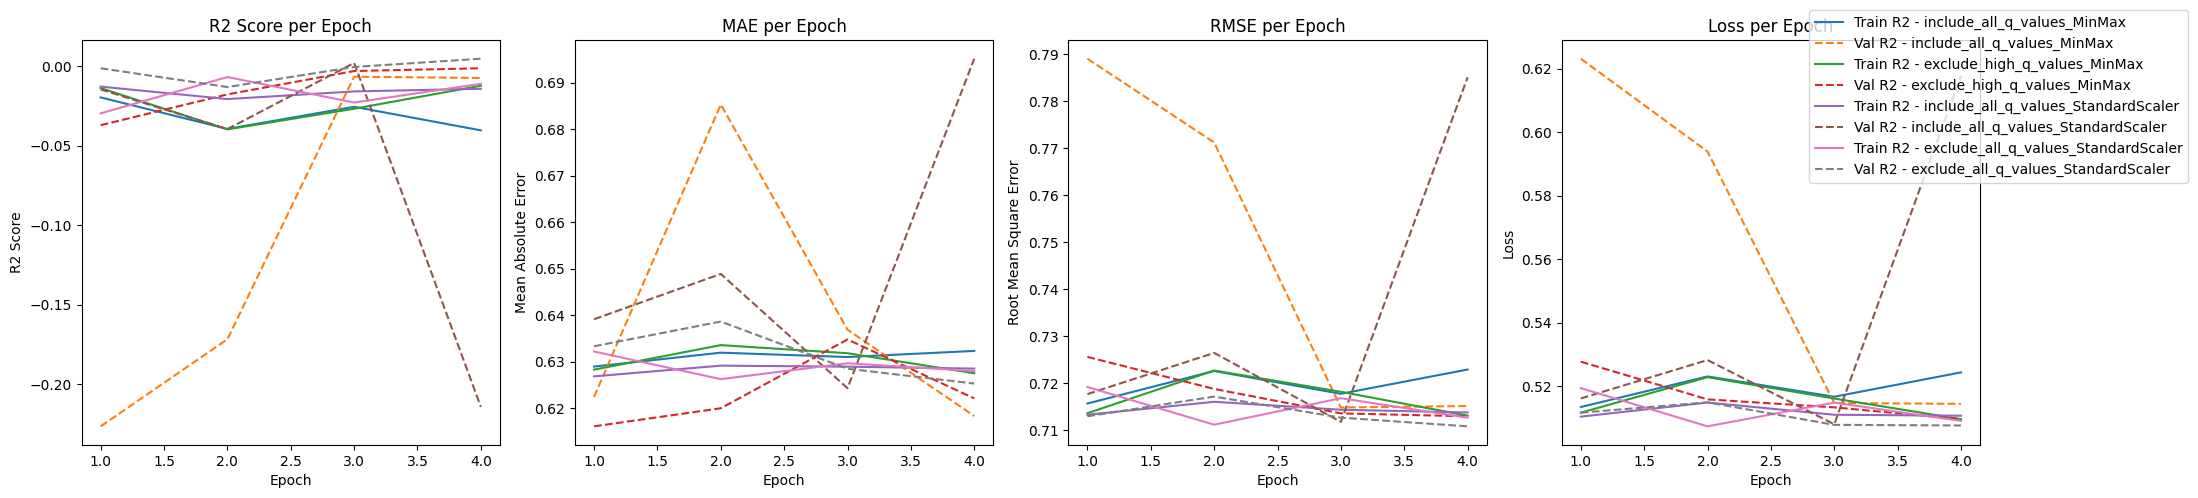

In [ ]:
# Assuming num_epochs and history_across_all_training_slices are defined

epochs = range(1, num_epochs + 1)
metrics = ['r2', 'mae', 'rmse', 'loss']
titles = ['R2 Score per Epoch', 'MAE per Epoch', 'RMSE per Epoch', 'Loss per Epoch']
y_labels = ['R2 Score', 'Mean Absolute Error', 'Root Mean Square Error', 'Loss']

# Create a figure object to manage overall plot properties
fig, axs = plt.subplots(1, 4, figsize=(25, 5))  # Adjust the figure size based on your display/requirements

# Collect handles and labels for the legend
handles, labels = [], []

for i, metric in enumerate(metrics):
    ax = axs[i]  # Use subplot axis for plotting
    for slice_key, history in history_across_all_training_slices.items():
        train_metric = history[f'train_{metric}']
        val_metric = history[f'val_{metric}']
        handle1, = ax.plot(epochs, train_metric, label=f'Train {metric.upper()} - {slice_key}')
        handle2, = ax.plot(epochs, val_metric, label=f'Val {metric.upper()} - {slice_key}', linestyle='--')

        # Add handles for the first iteration to avoid duplicates in the legend
        if i == 0:
            handles.extend([handle1, handle2])
            labels.extend([f'Train {metric.upper()} - {slice_key}', f'Val {metric.upper()} - {slice_key}'])

    ax.set_title(titles[i])
    ax.set_xlabel('Epoch')
    ax.set_ylabel(y_labels[i])

# Place a single legend on the right side of the figure
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()


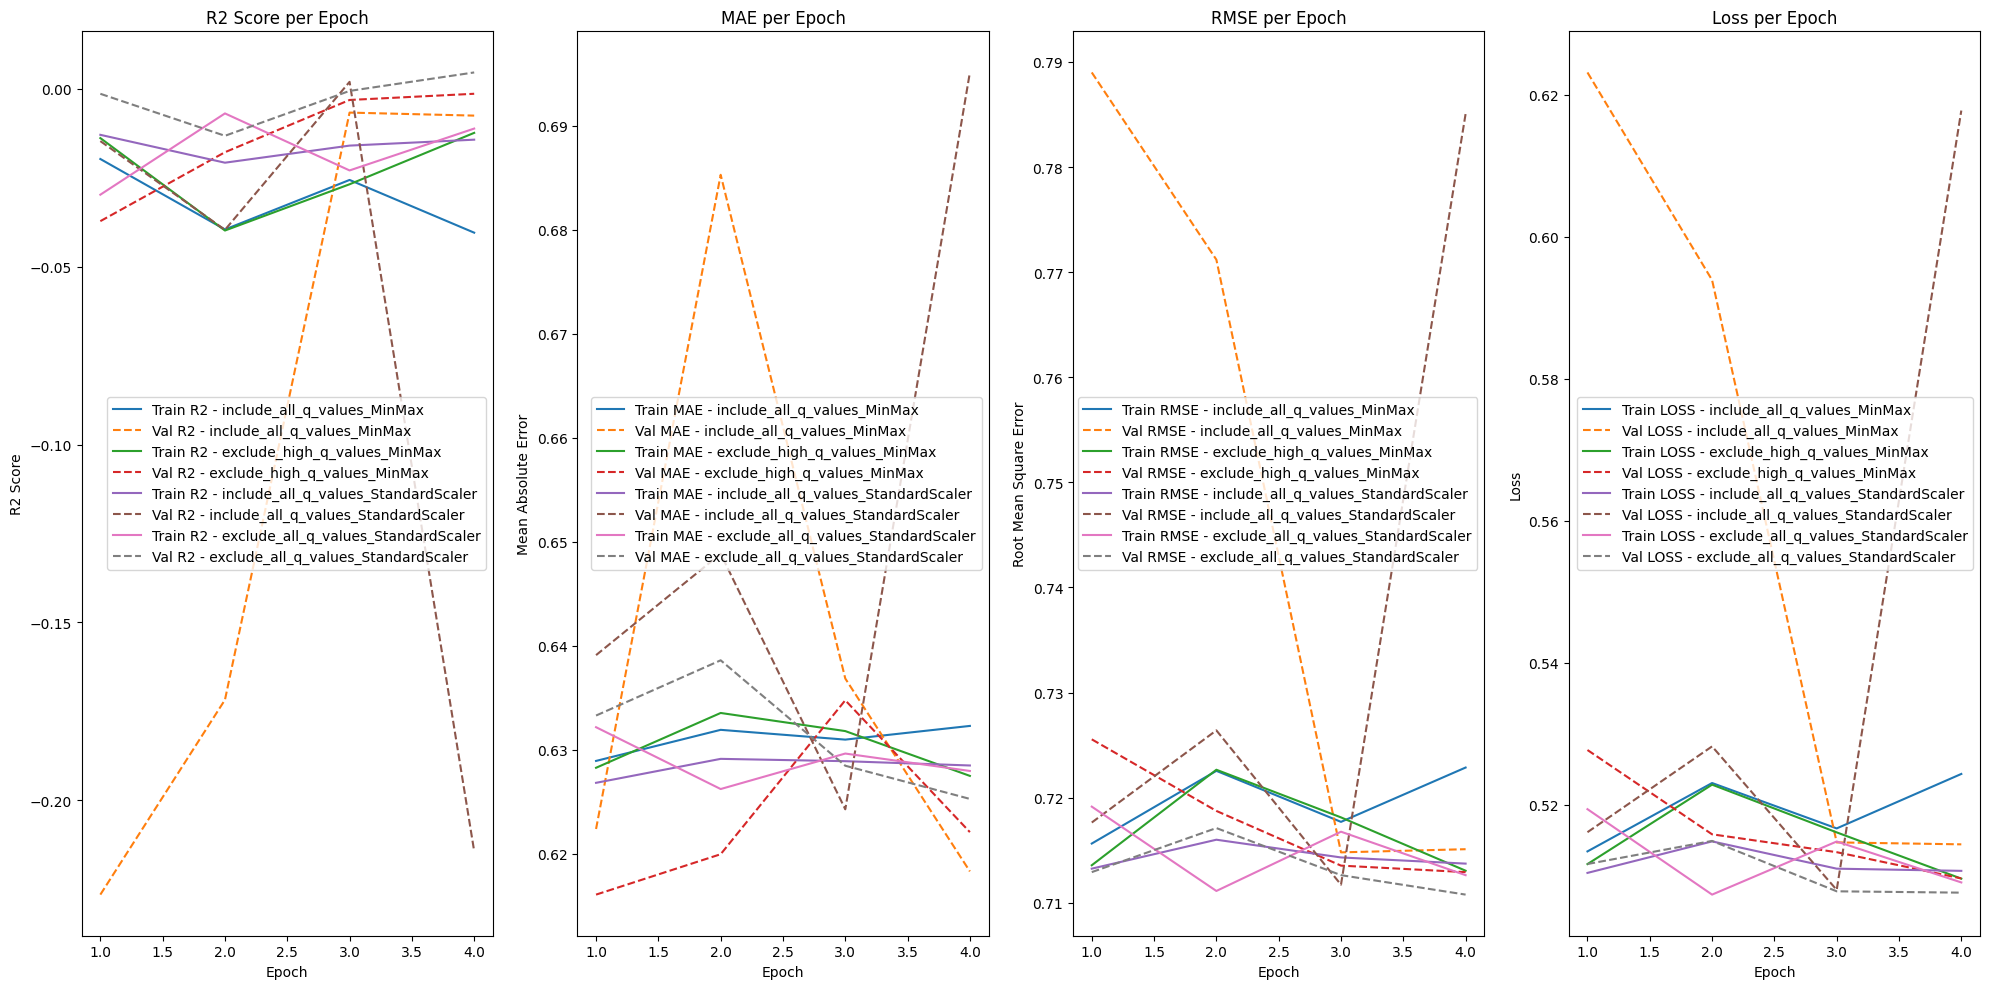

In [116]:
# Number of epochs should be consistent across all slices if your training regimen does not change
epochs = range(1, num_epochs + 1)

# Create a separate figure for each metric to compare across slices
metrics = ['r2', 'mae', 'rmse', 'loss']
titles = ['R2 Score per Epoch', 'MAE per Epoch', 'RMSE per Epoch', 'Loss per Epoch']
y_labels = ['R2 Score', 'Mean Absolute Error', 'Root Mean Square Error', 'Loss']

plt.figure(figsize=(20, 10))  # Adjust the figure size based on your display/requirements

for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i + 1) # 4 subplots for 4 metrics

    for slice_key, history in history_across_all_training_slices.items():
        train_metric = history[f'train_{metric}']
        val_metric = history[f'val_{metric}']
        plt.plot(epochs, train_metric, label=f'Train {metric.upper()} - {slice_key}')
        plt.plot(epochs, val_metric, label=f'Val {metric.upper()} - {slice_key}', linestyle='--')

    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel(y_labels[i])
    plt.legend(loc='best')  # dynamically adjust the legend location

plt.tight_layout()
plt.show()

### Individual training slice visualization


In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

# Example of plotting R-squared scores for training and validation
plt.subplot(1, 4, 1)
plt.plot(epochs, history['train_r2'], label='Train R2')
plt.plot(epochs, history['val_r2'], label='Validation R2')
plt.title('R2 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()

# Plotting MAE and RMSE similarly
plt.subplot(1, 4, 2)
plt.plot(epochs, history['train_mae'], label='Train MAE')
plt.plot(epochs, history['val_mae'], label='Validation MAE')
plt.title('MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(epochs, history['train_rmse'], label='Train RMSE')
plt.plot(epochs, history['val_rmse'], label='Validation RMSE')
plt.title('RMSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error')
plt.legend()

#Let plot the loss
plt.subplot(1,4,4)
plt.plot(epochs, history['train_loss'], label = 'Training Loss')
plt.plot(epochs, history['val_loss'], label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend

plt.tight_layout()
plt.show()